In [1]:
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
plt.style.use('seaborn-paper')
#print(plt.style.available)

In [2]:
import utils
import plotting
import helper 
# Hack for notebooks
import importlib
importlib.reload(utils)
importlib.reload(helper)
importlib.reload(plotting)

from helper import *
from utils import *
from analytical_solutions import *

In [3]:
device = get_device()
set_seed()

Using the CPU


Firstly, we make a dataset of the pendulum trajectory.

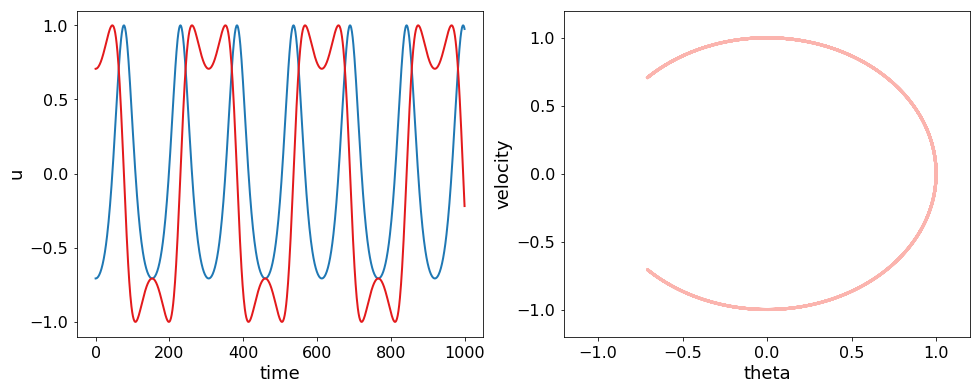

In [4]:
t_max = 10
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0,t_max,N_time_step)
data = solution_pendulum_xy(anal_ts, 1.5*np.pi/2)
plotting.trajectory_plots([data])

In [57]:
torch_ts = data_to_torch(anal_ts,device)#.reshape(-1,1)
torch_data = data_to_torch(data,device)#.reshape(-1,1,data.shape[-1])

# Learn a discrete RNN

In [20]:
class RNN(torch.nn.Module):
    def __init__(self,dim,hidden=10):
        super(RNN,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim,hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden,dim),
        )
    def forward(self,x):
        return self.net(x)

In [7]:
def learn_rnn(data, model=None, batch_size=25, n_future=1, verbose=False, device=None):
    """Perform the one-step learning for a linear matrix."""
    if device is None:
        device = get_device()

    if model==None:
        model = torch.nn.Linear(2,2,bias=False).double().to(device)
    optim = torch.optim.Adam(model.parameters(),1.0e-4)
    loss = torch.nn.MSELoss()
    losses=[]

    N_iter = 50000
    N_print = N_iter
    N_trace = 100
    nsamp = data.shape[0] # The harmonic oscillator is periodic so a test set is meaningless
    for opt_iter in range(N_iter):
        idcs = torch.LongTensor(np.random.choice(nsamp-n_future, size=batch_size)).to(device)
        yy = [ torch.index_select(data ,0, idcs+i) for i in range(n_future+1) ]
        yy_pred = model(yy[0])
        L = loss(yy[1], yy_pred) # n_future=1
        # try multiple steps into the future
        for fut in range(2,n_future+1):
            yy_pred = model(yy_pred)
            L += loss(yy[fut], yy_pred)
        # Do the backward step and optimize
        optim.zero_grad()
        L.backward()
        optim.step()
        losses.append(L.cpu().detach().numpy())
        # Save omega to let us analyze its trajectory
        #if opt_iter%N_trace==N_trace-1:
        #    omega_trace.append(model.weight.data.cpu().numpy())
        # Print diagonistics during training
        if verbose and opt_iter%N_print==N_print-1:
            print(opt_iter,L.item())
            #print(list(model.parameters()))
            #integrate_and_plot(model, ylim=None,nsteps=1000)
    if verbose:
        print("Converged with L1: ",losses[-1])
        #plt.semilogy(losses)
    return model, np.array(losses),

In [23]:
model = RNN(4,hidden=50).double()

In [24]:
model(torch_data[0,:])

tensor([ 0.1577,  0.0875, -0.0240, -0.0417], dtype=torch.float64,
       grad_fn=<AddBackward0>)

In [9]:
_,losses = learn_rnn(torch_data, model)

Using the CPU


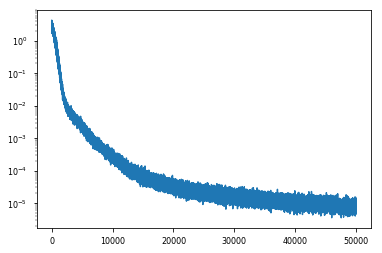

In [10]:
plt.semilogy(losses)

In [11]:
ys = []
y0 = data_to_torch([1,0,0,0],device=device)
with torch.no_grad():
    for i in range(50):
        yn = model(y0)
        y0 = yn
        ys.append(yn.cpu().numpy())
    ys = np.array(ys)

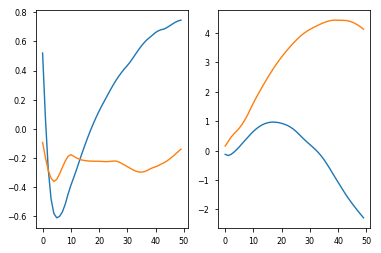

In [12]:
plt.subplot(1,2,1)
plt.plot(ys[:,0])
plt.plot(ys[:,1])
plt.subplot(1,2,2)
plt.plot(ys[:,2])
plt.plot(ys[:,3])

# Learn a Neural ODE

In [13]:
import torchdiffeq

In [58]:
def learn_rnn(data, model=None, batch_size=25, n_future=1, 
              learning_rate = 1.0e-4,
              verbose=False, device=None):
    """Perform the one-step learning for a linear matrix."""
    if device is None:
        device = get_device()
    if model==None:
        model = torch.nn.Linear(2,2,bias=False).double().to(device)
    optim = torch.optim.Adam(model.parameters(),1.0e-4)
    loss = torch.nn.MSELoss()
    losses=[]

    N_iter = 50000
    N_print, N_trace = N_iter, 100
    nsamp = data.shape[0] # The harmonic oscillator is periodic so a test set is meaningless
    for opt_iter in range(N_iter):
        idcs = torch.LongTensor(np.random.choice(nsamp-n_future, size=batch_size)).to(device)
        yy = [ torch.index_select(data ,0, idcs+i) for i in range(n_future+1) ]
        yy_pred = model(yy[0])
        L = loss(yy[1], yy_pred) # n_future=1
        # try multiple steps into the future
        for fut in range(2,n_future+1):
            yy_pred = model(yy_pred)
            L += loss(yy[fut], yy_pred)
        # Do the backward step and optimize
        optim.zero_grad()
        L.backward()
        optim.step()
        losses.append(L.cpu().detach().numpy())
        # Print diagonistics during training
        if verbose and opt_iter%N_print==N_print-1:
            print(opt_iter,L.item())
    if verbose:
        print("Converged with L1: ",losses[-1])
    return model, np.array(losses),

In [59]:
class ODE_Func(torch.nn.Module):
    def __init__(self,dim,hidden=10):
        super(ODE_Func,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim,hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden,dim),
        )
    def forward(self,t,x):
        return self.net(x)

In [80]:
def train_a_neural_ode(data, ts, model=None, batch_size=25, n_future=1, 
                       learning_rate = 1.0e-4,
                       verbose=False, device=None, method='euler'):
    if device is None:
        device = get_device()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    N_iter = 10000
    N_print, N_trace = N_iter, 100
    for itr in range(1, N_iter):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch(data, ts,
                                               batch_size, n_future+1)
        #print(batch_t)
        #print(batch_y)
        pred_y = torchdiffeq.odeint(model, batch_y0, batch_t,
                                    method=method)
        #print(pred_y)
        #print(pred_y-batch_y)
        #print(batch_y0)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        #print(loss)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().numpy())
        if itr % 1000 == 0:
            with torch.no_grad():
                pred_y = torchdiffeq.odeint(model, batch_y0, batch_t)
                loss = torch.mean(torch.abs(pred_y - batch_y))
    return model,np.array(losses)

In [81]:
model=ODE_Func(4, hidden=50).double()

In [82]:
model,losses = train_a_neural_ode(torch_data,torch_ts, model=model, device=device, batch_size=2, method='rk4')

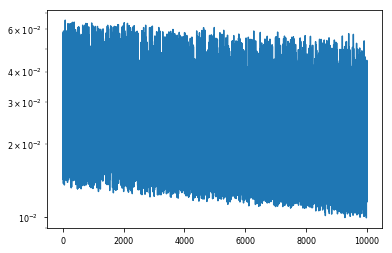

In [83]:
plt.semilogy(losses)

In [85]:
pred = torchdiffeq.odeint(model, torch_data[0,:], torch_ts)

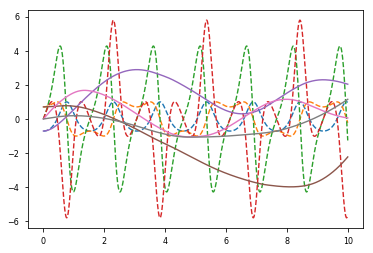

In [87]:
plt.plot(torch_ts.cpu().numpy(), torch_data.detach().cpu().numpy(), '--')
plt.plot(torch_ts.cpu().numpy(), pred.detach().cpu().numpy())

# Correctly learn the dynamics

# Compare the results